In [25]:
import numpy as np
import pandas as pd
import utilities as utils
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

In [2]:
rawdata = pd.read_csv("world-food-facts/FoodFacts.csv")

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
not_null_data = rawdata[rawdata.nutrition_score_uk_100g.notnull()]

In [4]:
nutriment_cols = [col for col in not_null_data.columns if '_100g' in col and not 'score' in col]
data = not_null_data[nutriment_cols]
data = data.fillna(0) #fill nulls with 0 for now
data.shape

(31294, 94)

In [5]:
target = not_null_data.nutrition_score_uk_100g.loc[data.index.values]
target.shape

(31294,)

### Linear regression to predict nutrition score

In [6]:
x = data.as_matrix()
y = target.as_matrix()

In [7]:
x = np.array([np.concatenate((v,[1])) for v in x]) #add column of ones to the end of the data set
print x

[[ 1284.      0.      7.      3.6 ...,     0.      0.      0.      1. ]
 [ 1284.      0.      7.      3.6 ...,     0.      0.      0.      1. ]
 [  177.      0.      0.      0.  ...,     0.      0.      0.      1. ]
 [  177.      0.      0.      0.  ...,     0.      0.      0.      1. ]
 ..., 
 [ 2111.      0.     53.3     3.8 ...,     0.      0.      0.      1. ]
 [  660.      0.      6.9     0.5 ...,     0.      0.      0.      1. ]
 [ 1643.      0.      2.8     0.6 ...,     0.      0.      0.      1. ]
 [   21.      0.      0.2     0.2 ...,     0.      0.      0.      1. ]]


In [8]:
linreg = LinearRegression()
linreg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
p = linreg.predict(x)
p

array([ 10.81,  10.81,   0.62,   0.66, ...,  15.35,   4.36,   3.81,  -1.75])

In [10]:
err = abs(p-y)
err

array([ 0.81,  0.81,  1.38,  1.34, ...,  1.65,  1.64,  7.81,  1.75])

In [11]:
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))
rmse_train

4.6161598836408091

In [12]:
linreg.coef_ #Regression Coefficients

array([      0.  ,       0.  ,       0.09,       0.32,       0.  ,       0.  ,       0.  ,       0.  ,      -0.77,
            -0.  ,      -0.  ,      -0.  ,      -7.28,       0.  ,       0.  ,      -0.  ,      -0.  ,      -0.  ,
            -0.08,      -0.05,      -0.1 ,      -0.02,       7.75,      -4.79,      -0.04,       0.15,     116.67,
         -6932.67,       0.  ,      -0.04,      -0.06,      -0.  ,      -0.  ,       0.  ,       0.  ,       0.  ,
             0.  ,      -1.5 ,      -0.04,       0.21,       0.15,       0.  ,      -0.07,      -0.05,       0.02,
             0.02,       0.01,       0.04,      -0.57,       0.16,       0.19,      -0.09,    -353.97,     117.67,
          -297.78,       0.07,      31.08,      17.76,       0.41,      -0.1 ,     -27.46,      -0.73,     -82.62,
           384.48,       0.02,     -27.13,      12.51,  251068.35,  -22217.04,       2.13,    -156.01,      48.78,
            -0.09,      14.35,       0.09,      -7.3 ,      -0.04,       8.08,  

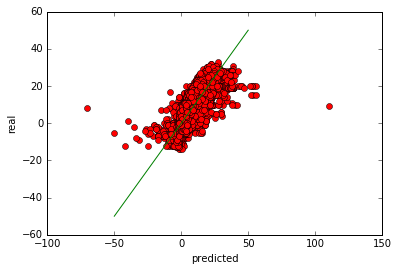

In [13]:
pl.plot(p, y,'ro')
pl.plot([-50,50],[-50,50], 'g-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [14]:
# RMSE with 10-Fold Cross Validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    linreg.fit(x[train],y[train])
    p = linreg.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
    
rmse_10cv = np.sqrt(xval_err/len(x))

In [16]:
print('Method: Linear Regression')
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Linear Regression
RMSE on training: 4.6162
RMSE on 10-fold CV: 1418.3081


In [19]:
# Create linear regression object with a ridge coefficient 0.5
ridge = Ridge(fit_intercept=True, alpha=0.5)

# Train the model using the training set
ridge.fit(x,y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [20]:
# Compute RMSE on training data
# p = np.array([ridge.predict(xi) for xi in x])
p = ridge.predict(x)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    ridge.fit(x[train],y[train])
    p = ridge.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Ridge Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Ridge Regression
RMSE on training: 4.6456
RMSE on 10-fold CV: 4.9892


In [21]:
print('Ridge Regression')
print('alpha\t RMSE_train\t RMSE_10cv\n')
alpha = np.linspace(.01,20,50)
t_rmse = np.array([])
cv_rmse = np.array([])

for a in alpha:
    ridge = Ridge(fit_intercept=True, alpha=a)
    
    # computing the RMSE on training data
    ridge.fit(x,y)
    p = ridge.predict(x)
    err = p-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(p))

    # computing RMSE using 10-fold cross validation
    kf = KFold(len(x), n_folds=10)
    xval_err = 0
    for train, test in kf:
        ridge.fit(x[train], y[train])
        p = ridge.predict(x[test])
        err = p - y[test]
        xval_err += np.dot(err,err)
    rmse_10cv = np.sqrt(xval_err/len(x))
    
    t_rmse = np.append(t_rmse, [rmse_train])
    cv_rmse = np.append(cv_rmse, [rmse_10cv])
    print('{:.3f}\t {:.4f}\t\t {:.4f}'.format(a,rmse_train,rmse_10cv))

Ridge Regression
alpha	 RMSE_train	 RMSE_10cv

0.010	 4.6431		 28.8886
0.418	 4.6456		 5.0328
0.826	 4.6458		 4.8922
1.234	 4.6459		 4.8361
1.642	 4.6460		 4.8067
2.050	 4.6460		 4.7894
2.458	 4.6461		 4.7785
2.866	 4.6461		 4.7712
3.274	 4.6462		 4.7661
3.682	 4.6462		 4.7623
4.090	 4.6463		 4.7595
4.498	 4.6463		 4.7574
4.906	 4.6463		 4.7557
5.313	 4.6464		 4.7543
5.721	 4.6464		 4.7532
6.129	 4.6465		 4.7523
6.537	 4.6465		 4.7515
6.945	 4.6465		 4.7508
7.353	 4.6466		 4.7501
7.761	 4.6466		 4.7496
8.169	 4.6467		 4.7491
8.577	 4.6467		 4.7486
8.985	 4.6467		 4.7482
9.393	 4.6468		 4.7478
9.801	 4.6468		 4.7474
10.209	 4.6468		 4.7471
10.617	 4.6469		 4.7467
11.025	 4.6469		 4.7464
11.433	 4.6470		 4.7461
11.841	 4.6470		 4.7458
12.249	 4.6470		 4.7455
12.657	 4.6471		 4.7453
13.065	 4.6471		 4.7450
13.473	 4.6471		 4.7447
13.881	 4.6472		 4.7445
14.289	 4.6472		 4.7442
14.697	 4.6472		 4.7440
15.104	 4.6473		 4.7437
15.512	 4.6473		 4.7435
15.920	 4.6473		 4.7433
16.328	 4.6474		 

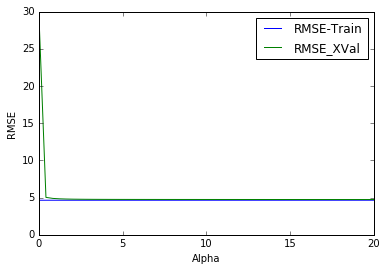

In [22]:
pl.plot(alpha, t_rmse, label='RMSE-Train')
pl.plot(alpha, cv_rmse, label='RMSE_XVal')
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.show()

In [24]:
a = 0.3
for name,met in [
        ('linear regression', LinearRegression()),
        ('lasso', Lasso(fit_intercept=True, alpha=a)),
        ('ridge', Ridge(fit_intercept=True, alpha=a)),
        ('elastic-net', ElasticNet(fit_intercept=True, alpha=a))
        ]:
    met.fit(x,y)
    # p = np.array([met.predict(xi) for xi in x])
    p = met.predict(x)
    e = p-y
    total_error = np.dot(e,e)
    rmse_train = np.sqrt(total_error/len(p))

    kf = KFold(len(x), n_folds=10)
    err = 0
    for train,test in kf:
        met.fit(x[train],y[train])
        p = met.predict(x[test])
        e = p-y[test]
        err += np.dot(e,e)

    rmse_10cv = np.sqrt(err/len(x))
    print('Method: %s' %name)
    print('RMSE on training: %.4f' %rmse_train)
    print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
    print "\n"

Method: linear regression
RMSE on training: 4.6162
RMSE on 10-fold CV: 1418.3081


Method: lasso
RMSE on training: 4.6684
RMSE on 10-fold CV: 4.7072


Method: ridge
RMSE on training: 4.6454
RMSE on 10-fold CV: 5.1338


Method: elastic-net
RMSE on training: 4.6653
RMSE on 10-fold CV: 4.7074




In [27]:
scaler = StandardScaler()
scaler.fit(x)
x_s = scaler.transform(x)
print x_s

sgdreg = SGDRegressor(penalty='l2', alpha=0.15, n_iter=200)

# Compute RMSE on training data
sgdreg.fit(x_s,y)
p = sgdreg.predict(x_s)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    scaler = StandardScaler()
    scaler.fit(x[train])  # Don't cheat - fit only on training data
    xtrain_s = scaler.transform(x[train])
    xtest_s = scaler.transform(x[test])  # apply same transformation to test data
    sgdreg.fit(xtrain_s,y[train])
    p = sgdreg.predict(xtest_s)
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Stochastic Gradient Descent Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

[[ 0.26 -0.1  -0.35 -0.19 ..., -0.1   0.   -0.04  0.  ]
 [ 0.26 -0.1  -0.35 -0.19 ..., -0.1   0.   -0.04  0.  ]
 [-1.15 -0.1  -0.77 -0.65 ..., -0.1   0.   -0.04  0.  ]
 [-1.15 -0.1  -0.77 -0.65 ..., -0.1   0.   -0.04  0.  ]
 ..., 
 [ 1.31 -0.1   2.41 -0.17 ..., -0.1   0.   -0.04  0.  ]
 [-0.54 -0.1  -0.36 -0.59 ..., -0.1   0.   -0.04  0.  ]
 [ 0.71 -0.1  -0.6  -0.57 ..., -0.1   0.   -0.04  0.  ]
 [-1.35 -0.1  -0.76 -0.63 ..., -0.1   0.   -0.04  0.  ]]
Method: Stochastic Gradient Descent Regression
RMSE on training: 82029857767.1123
RMSE on 10-fold CV: 29285661876483.3477
